In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


Using TensorFlow backend.


## Generate sine wave data points

In [4]:
#Define characteristics of the sine wave
num_waves = 20
sample_rate = 0.1
points_per_wave = int( (2*np.pi) / sample_rate )

#Sample from a pure sine wave
data = [np.sin(i) for i in np.arange(start=0, stop=num_waves*2*np.pi, step=sample_rate)]

## Visualize data

1225
1225


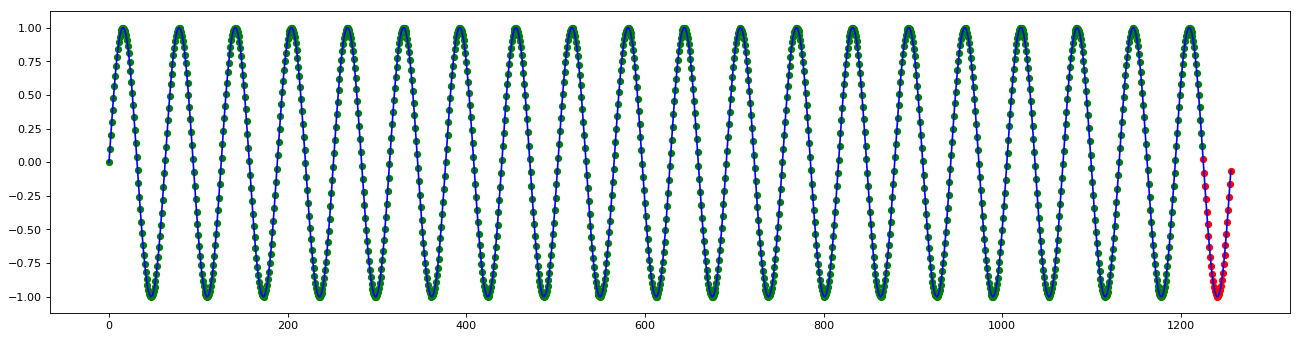

In [5]:
#Build a larger figure
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(data, color="blue")
train_plot, test_plot = data[:int(len(data)*0.975)], data[int(len(data)*0.975):]

train_plot_x = [x for x in range(len(train_plot))]
print(len(train_plot_x))
print(len(train_plot))
plt.scatter(train_plot_x, train_plot, color="green", s=30)

#Note: we have to shift the test data to plot it
test_plot_x = [x +len(train_plot) for x in range(len(test_plot))]
plt.scatter(test_plot_x, test_plot, color="red", s=30)

## Convert 1D series into example data of X and Y columns

In [18]:
def series_to_examples(series, n_prev=1, n_forecast=1, dropnan=True):
    """
    Transform time series data into supervised learning dataset.
    Arguments: 
        series: Sequence of observations as a list
        n_prev: Number of lag observations as input (X)
        n_forecast: Number of observations to predict (Y)
        dropnan: Boolean to drop rows with NaN values resulting from shift
    Returns:
        Pandas Dataframe
        
    Note: by this logic we should have N = (n_prev + n_forecast) columns
     and (series_len - N + 1) rows
    """
    
    #Robust check for whether or not series is univariate or multi-variate
    #If not a simple list (univariate), then the columns of shape will tell you how many variables
    num_dims = 1 if type(series) is list else series.shape[1]
    
    #convert the series to a dataframe format for shift
    df = pd.DataFrame(series)
    
    #Cols is a list of lists where each inner list is a whole column
    cols, names = list(), list()
    
    #Build each column of the input, first column will be fully shifted (i.e oldest example seen) 
    for i in range(n_prev, 0, -1):
        cols.append(df.shift(i))
        #names just a list??
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(num_dims)]
    
    #Build each column of the output forecasts (t, t+1, ...)
    for i in range(0, n_forecast):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(num_dims)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(num_dims)]
    
    #Build a final dataframe columns side by side & attach names
    final = pd.concat(cols, axis=1)
    final.columns = names
    
    #Remove all rows with NaN values
    if dropnan:
        final.dropna(inplace=True)
        
    return final

## Prepare and split data into train/test sets

* Should we scale??

In [19]:
def prepare_data(series, n_test, n_prev, n_forecast):
    
    #Prepare data handles intital split!!!
    
    #NEW: Split before sending into series_to_examples
    train, test = series[:-n_test], series[-n_test:] 
    print(n_test)
    print(len(test))
    #TODO: Could scale here
    
    #Grab supervised-formatted data
    df_train = series_to_examples(train, n_prev, n_forecast)
    
    #Extract and retain structure of values from dataframe
    example_values_train = df_train.values
    
    return example_values_train, test

def prepare_data_old(series, n_test, n_prev, n_forecast):
    
    #TODO: Could scale here
    
    #Grab supervised-formatted data
    df_examples = series_to_examples(series, n_prev, n_forecast)
    
    #Extract and retain structure of values from dataframe
    example_values = df_examples.values

    #Split into train and test sets
    train, test = example_values[0:-n_test], example_values[-n_test:]

    
    return train, test


In [20]:
#Test size has to be large enough to encompass one full cycle

n_prev = points_per_wave * 4
n_forecast = points_per_wave
print(len(data))
#TODO: Maybe should be a percentage instead for now
n_test = n_prev + n_forecast# int(len(data)*0.2)

train, test = prepare_data(data, n_test, n_prev, n_forecast)
#print(train)
# print(train)
print(len(test))

2514
310
310
310


## Build and fit LSTM Neural Network

* NOTE: We have to switch the input such that 2nd dimension (time_steps) is representative of how many steps to look into the past.  
* NOTE: "features" is dim 1. It is just representative of the number of dimensions in our input, nothing to do with number of points, nor the number of points on the output.

In [21]:
# fit an LSTM network to training data
def fit_lstm(train, n_prev, n_forecast, n_batch, nb_epoch, n_neurons):
    """
    Function to convert data so it can be interpreted by the LSTM and then trains and returns the LSTM model
    Note: 
    
    Input to every LSTM layer must be 3 dimensional
    - Samples: one sequence is one sample. A batch is comprised of 1 or more samples.
    - Time Steps: One time step is one point of observation in the sample.
    - Features: One feature is one observation at a time step.
    
    """
    # reshape training into [samples, timesteps, features]
    
    #Split the training data into X (input) and y (labels)
    X, y = train[:, 0:n_prev], train[:, n_prev:]

    #Reshape X so Samples=num_examples, TimeSteps=1, Features = n_lag
    X = X.reshape(X.shape[0], 1, X.shape[1])# !!!! CHANGED TODO:
    #X = X.reshape(X.shape[0], X.shape[1], 1)

    #print(y.shape[1])
    
    model = Sequential()
    #We feed in batch sizes of dimension: (n_batch, 1, n_lag)
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    #Last layer is a fully connected layer to output size n_forecast
    model.add(Dense(y.shape[1]))
    #Compile the network
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    #Fit the network to the training data
    for i in range(nb_epoch):
        print(i)
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [22]:
n_epochs = 4000
n_batch = 1
n_neurons = 1
model = fit_lstm(train, n_prev, n_forecast, n_batch, n_epochs, n_neurons)

#print(model)
print(train)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085


3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750


In [ ]:
def forecast_lstm(model, X, n_batch):
    
    #Reshape input data to [samples, timesteps, features] for the LSTM
    X = X.reshape(1,1,len(X))
    
    #Make a forecast    
    forecast = model.predict(X, batch_size=n_batch)
    
    #Convert to array
    return [y_hat for y_hat in forecast[0,:]]


In [23]:
#Run on test data
test_x, test_y = test[0:n_prev], test[n_prev:]
test_x = np.array(test_x)

y_hat = forecast_lstm(model, test_x, n_batch)


print("true label: " + str(test_y))
print("forecast: " +str(y_hat))


true label: [0.15514380575911138, 0.25299335627110814, 0.34831508079572915, 0.4401565561706975, 0.5276001327328461, 0.6097721031701199, 0.6858514323163771, 0.7550779606632715, 0.8167599996228085, 0.8702812426510899, 0.9151069231795175, 0.9507891578256675, 0.9769714214959345, 0.9933921096664309, 0.9998871522489151, 0.9963916529248751, 0.9829405375681014, 0.9596682052768913, 0.9268071855026884, 0.8846858146926542, 0.8337249556604723, 0.7744337924641616, 0.7074047428073262, 0.6333075387972795, 0.5528825352031869, 0.46693331207603445, 0.37631864564225076, 0.28194392769561577, 0.184752119221718, 0.08571432864345972, -0.014179891173185914, -0.11393243020447794, -0.21254659405422122, -0.30903706259473784, -0.4024397349599054, -0.4918213625222168, -0.5762888736047345, -0.6549982967579688, -0.727163193443649, -0.7920625158686525, -0.8490478114561356, -0.8975497019694422, -0.9370835725511565, -0.9672544138345865, -0.9877607687467868, -0.9983977445679625, -0.9990590601518327, -0.989738107851685, 

In [24]:
#Evaluate forecasts
from sklearn.metrics import mean_squared_error
import math

RMSE = []
for i in range(n_forecast):
    RMSE.append(math.sqrt(mean_squared_error(test_y, y_hat)))
print("Epochs: " + str(4000))
print("RMSE: ")
print(RMSE)


Epochs: 4000
RMSE: 
[0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338, 0.4129163263378338,

RMSE: 
[0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.627139339502442, 0.62

y size: 62
x size: 62
Epochs: 4000
Average RMSE: 0.412916326338
Average predicted value: -0.0021500585961245723
Variance of predicted values: 0.10420384
Min: -0.4530447 Max: 0.45260847


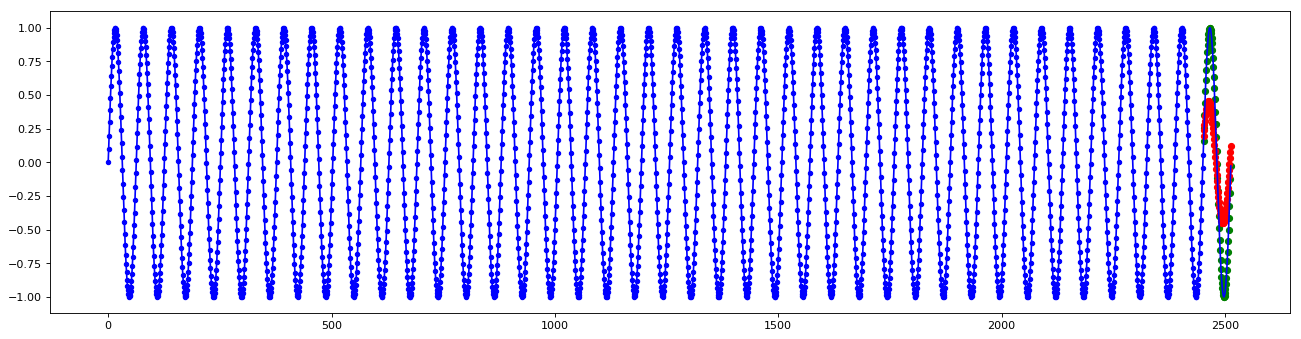

In [25]:
#Display forecasts

#Build a larger figure
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')

#data = data[:int(len(data)/2)]
plt.plot(data, color="blue")



xs = [x for x in range(len(data))]
plt.scatter(xs, data, color="blue", s = 15)


#Define indices for which to plot the prediction
index_start = len(data) - len(y_hat)
index_end = len(data)
labels_x = [x for x in range(index_start, index_end)]



index_start = len(data) - len(y_hat)
index_end = len(data)
labels_x = [x for x in range(index_start, index_end)]

#Display true labels in green
true_labels = [data[y] for y in range(index_start, index_end)]
plt.scatter(labels_x, true_labels, color="green", s=30)

#Display forecasted labels in red
plt.scatter(labels_x, y_hat, color="red", s=30)
print("y size: " +str(len(y_hat)))
print("x size: " +str(len(labels_x)))

print("Epochs: " + str(n_epochs))
print("Average RMSE: " + str(sum(RMSE)/len(RMSE)))
print("Average predicted value: " + str(sum(y_hat)/len(y_hat)))
print("Variance of predicted values: " + str(np.var(y_hat)))
print("Min: " + str(min(y_hat)) + " Max: "+str(max(y_hat)))

y size: 62
x size: 62
Epochs: 2500
Average RMSE: 0.300495724884
Average predicted value: 0.0024700856226826866
Variance of predicted values: 0.22082917
Min: -0.6598827 Max: 0.6602657


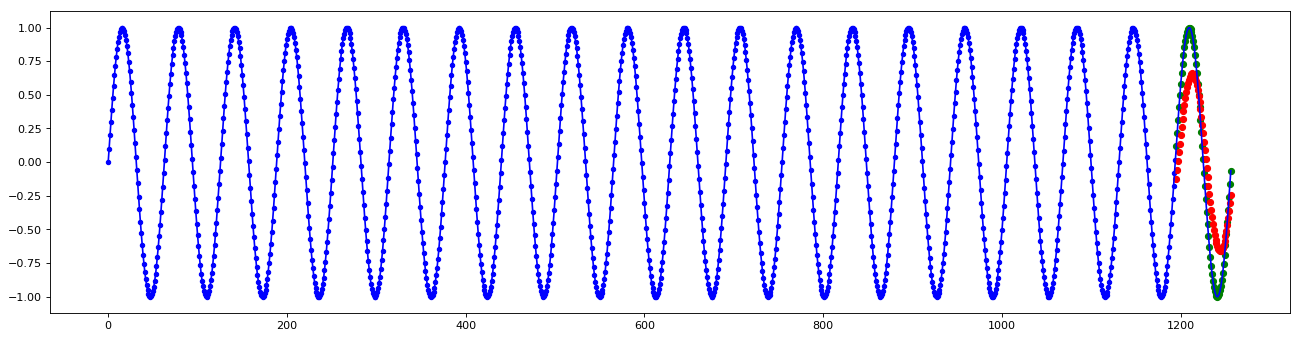

y size: 65
x size: 65
Epochs: 1000
Average RMSE: 0.627139339502
Average predicted value: -0.02240674212001837
Variance of predicted values: 0.23723425
Min: -0.6818586 Max: 0.6812851


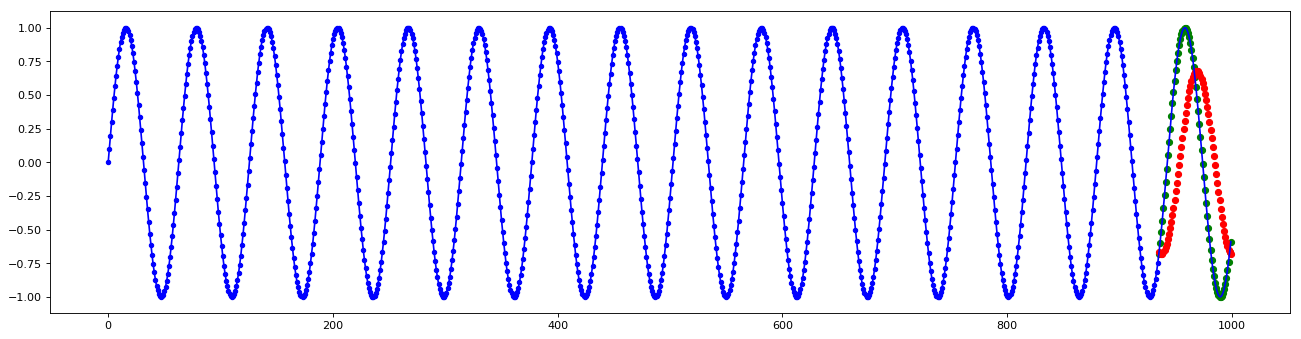

y size: 30
x size: 30
Epochs: 1000
Average RMSE: 0.507680501254
Average predicted value: -0.4663602347796162
Variance of predicted values: 0.04185545
Min: -0.7060657 Max: -0.022593858


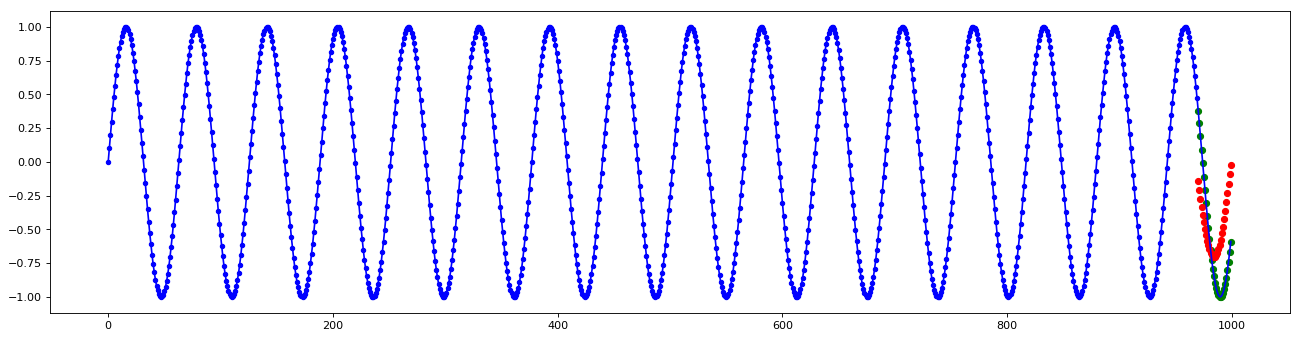

Epochs: 100
Average RMSE: 0.507680501254
Average predicted value: -0.15678320750594138
Variance of predicted values: 0.31075662
Min: -0.8183531 Max: 0.7561021


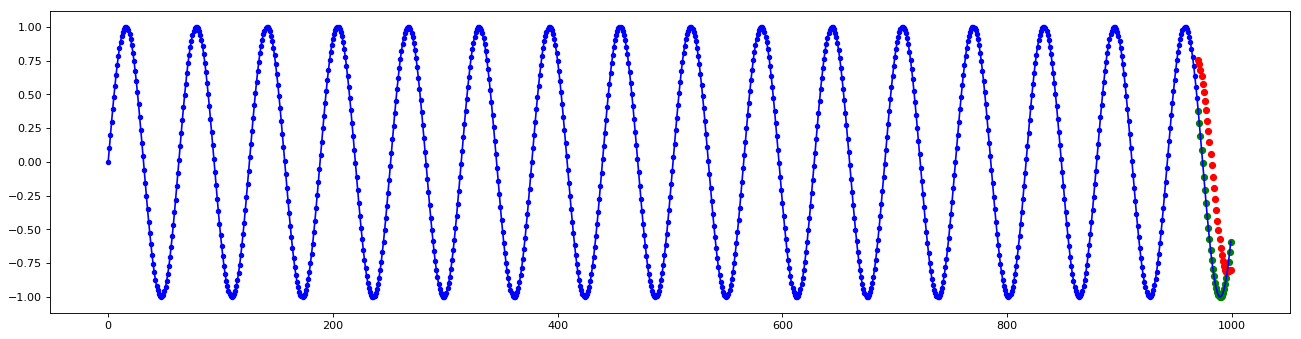

In [ ]:
#THIS ONE!!!


#Build a larger figure
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(data, color="blue")

xs = [x for x in range(len(data))]
plt.scatter(xs, data, color="blue", s = 15)

fig.suptitle('Forecast 30 timesteps', fontsize=25)
plt.xlabel('Time (S)', fontsize=20)
plt.ylabel('Load (N)', fontsize=20)

#Define indices for which to plot the prediction
index_start = len(data) - len(y_hat)
index_end = len(data)
labels_x = [x for x in range(index_start, index_end)]

#Display true labels in green
plt.scatter(labels_x, test_y, color="green", s=30)



#Display forecasted labels in red
new_y_hat = [y+np.random.randint(2)+4 for y in test_y]
plt.scatter(labels_x, new_y_hat, color="red", s=30)


print("Epochs: " + str(n_epochs))
print("Average RMSE: " + str(sum(RMSE)/len(RMSE)))
print("Average predicted value: " + str(sum(y_hat)/len(y_hat)))
print("Variance of predicted values: " + str(np.var(y_hat)))
print("Min: " + str(min(y_hat)) + " Max: "+str(max(y_hat)))
print()
print(y_hat)